# 3: Fermipy

There is a tool named Fermipy which was developed (mainly) by Matt Wood at NASA Goddard with the help of several others. It's very good at simplifying the whole Fermi analysis chain - as I will demonstrate shortly. 

## Intro

Fermipy takes a configuration file in the YAML format, and then uses this to run the whole analysis chain along with optimized fitting routines and several other bells and whistles to make your analysis **significantly** easier. Firstly let's have a look at the default config, which has all of the different possible parameters in it for your perusal.

In [1]:
!cat config.yaml

# NGC 1275 Configuration File

data:
  evfile : events.txt #our list of photon files
  scfile : data/L1910170847288E15477E17_SC00.fits #our spacecraft file

binning:
  roiwidth   : 15.0 # Let's keep a small roi
  binsz      : 0.1 # bin size in degrees
  binsperdec : 8 # Ebins per decade in energy - 10 is a good estimate

selection:
  emin : 100  #our minimum energy
  emax : 300000  #our maximum energy
  zmax : 90  #our zenith angle
  evclass : 128  #our event class
  evtype : 3  #our event type
  tmin : 283996802  #our minimum time
  tmax : 315532802  #our maximum time
  filter : DATA_QUAL>0 && LAT_CONFIG==1 #A standard filter for gtmktime
  target : 'NGC 1275' # As NGC 1275 is in our 4FGL catalogue, we can simply type its name in, instead of the ra and dec of the source.

gtlike:
  edisp : True # Enable energy dispersion
  irfs : 'P8R3_SOURCE_V3'
  edisp_disable  : ['isodiff', 'galdiff'] # Never enable energy dispersion for the isodiff or galdiff models

model:
  src_roiwidth : 20.0 #

Now let's load this up in Fermipy and see what we can do:

In [6]:
currentDir = %pwd
print(currentDir)

/workdir/local-test-three/Tutorial


In [3]:
import os

In [4]:
print(("{0}").format(os.environ['PFILES']))

KeyError: 'PFILES'

In [7]:
os.environ['PFILES'] = currentDir + "/NGC_1275_Fit"

In [8]:
print(("{0}").format(os.environ['PFILES']))

/workdir/local-test-three/Tutorial/NGC_1275_Fit


In [9]:
from fermipy.gtanalysis import GTAnalysis

# Create an analysis object from the config file

#gta = GTAnalysis('config.yaml', logging={'verbosity': 3})
gta = GTAnalysis('config.yaml', logging={'verbosity': 3}, fileio={'outdir': '/workdir/local-test-three/Tutorial/NGC_1275_Fit'}) # One can also pass in additional command line options here.

2021-08-20 14:02:38 INFO    GTAnalysis.__init__(): 
--------------------------------------------------------------------------------
fermipy version v1.0.1 
ScienceTools version unknown


here
here


We can normally ignore any 'warning' messages, they generally benign. Now we'll run our setup

In [10]:
gta.setup()

2021-08-20 14:02:45 INFO    GTAnalysis.setup(): Running setup.
2021-08-20 14:02:45 INFO    GTBinnedAnalysis.setup(): Running setup for component 00
2021-08-20 14:02:45 INFO    GTBinnedAnalysis.run_gtapp(): Running gtselect.


ValueError: ParFileError: .par file gtselect.par not found.

We can immediately see how powerful Fermipy is, based on the output (in the red textbox) of this one command. Based on our defined parameters in the config file. The setup has ran gtselect, and filtered our photon files in the same way that the command line tool would have, by ROI, time, event class and event type. It has then created a livetime cube, using gtltcube (actually, it skipped this step, because I created it for you, to save you some time). It then runs gtbin to bin our photons, gtexpcube2 to compute exposure, and gtsrcmaps, to generate a source map of our ROI. 

This is all exceptionally useful, as this allows us to essentially run all of the science tools from Tutorial 2, in one command, based on our input from the config file. It saves us time and effort, and reduces the odds of human error! Nice!

Now we've got our model set up, we should try and fit it to our data. The first method we can use is to optimise the fit. 

There are several methods of statistically fitting models, $ \chi ^2$ minimisation and linear regression being two you have probably encountered the most. As our data is multidimensional (in space, time and energy), we use a more suitable approach, as described in Mattox et al (1996) https://ui.adsabs.harvard.edu/abs/1996ApJ...461..396M/abstract, called Maximum Likelihood Estimation. 

Each source in our model has different parameters, with associated statistical likelihoods. By varying the parameters to maximise the likelihoods, we improve the fit of our model. This method is particularly suitable for our data and modelling. You don't need to know in great depth about MLE to do Fermi analysis, however it really gives you a greater appreciation of what you're doing matghematically. I'll leave it to you to research this yourseld.

The first thing we should do with our model is optimise it. Optimisation is a Fermipy routine which iteratively pushes the parameters of each source close to their global maxima, and thus gives us a reasonable fit for our model to the data.

Lets do it!


In [8]:
gta.optimize()

2021-05-06 11:04:04 INFO    GTAnalysis.optimize(): Starting


Joint fit  ['galdiff', 'isodiff', '4FGL J0319.8+4130', '4FGL J0303.6+4716']


/home/max/anaconda2/envs/fermipy/lib/python2.7/site-packages/scipy/interpolate/fitpack2.py:224: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


Fitting shape galdiff TS:  32879.614
Fitting shape 4FGL J0319.8+4130 TS:   8253.125
Fitting shape isodiff TS:    903.294
Fitting shape 4FGL J0303.6+4716 TS:    624.138
Fitting shape 4FGL J0340.3+4130 TS:    278.004


2021-05-06 11:05:34 ERROR   GTAnalysis.fit(): MINUIT failed with status code 102 fit quality 2


Fitting shape 4FGL J0324.8+3412 TS:     58.575
Fitting shape 4FGL J0330.6+4659 TS:     31.077


2021-05-06 11:05:37 INFO    GTAnalysis.optimize(): Finished
2021-05-06 11:05:37 INFO    GTAnalysis.optimize(): LogLike: -207027.021736 Delta-LogLike: 385.886843
2021-05-06 11:05:37 INFO    GTAnalysis.optimize(): Execution time: 93.03 s


{'config': {'max_free_sources': 5,
  'npred_frac': 0.95,
  'npred_threshold': 1.0,
  'optimizer': {'init_lambda': 0.0001,
   'max_iter': 100,
   'min_fit_quality': 2,
   'optimizer': 'MINUIT',
   'retries': 3,
   'tol': 0.001,
   'verbosity': 0},
  'shape_ts_threshold': 25.0,
  'skip': []},
 'dloglike': 385.8868432891031,
 'loglike0': -207412.90857885612,
 'loglike1': -207027.02173556702}

There we go! Our optimization is finished and we should now have a model which represents the data in a much better way than before. But can we do better?

As mentioned, each source has a set of parameters, normalisation of the spectral power law, spectral shape etc. By freeing these parameters, we can execute a fit with respect to these. A fit provides a much better, well, fit, of the model to the data with respect to the freed parameters, however is very time consuming for our machines to do. In the case of NGC 1275 (which we are looking at) we probably want to fit the normalisation, and the normalisation of the sources around it. Parameters like spectral shape can be left alone, because we are pretty convinced that it is a point source, and there is no evidence for $\gamma$-ray extension.

First, we free the normalisation for a 3 degree region centered on NGC 1275, and also our background components in the model. 

In [9]:
gta.free_sources(distance=3.0,pars='norm') #frees the point sources
gta.free_source('galdiff', pars='norm') #frees the galactic diffuse
gta.free_source('isodiff', pars='norm') #frees the isotropic diffuse

2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0319.8+4130     : ['norm']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0316.8+4120     : ['Prefactor']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0315.5+4231     : ['Prefactor']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0312.9+4119     : ['Prefactor']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0311.6+4134     : ['Prefactor']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for 4FGL J0333.8+4007     : ['Prefactor']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for isodiff               : ['Normalization']
2021-05-06 11:05:37 INFO    GTAnalysis.free_source(): Freeing parameters for galdiff               : ['Prefactor']


Now our sources are freed, we can execute our fit with this simple command:

In [10]:
gta.fit()

2021-05-06 11:05:37 INFO    GTAnalysis.fit(): Starting fit.
2021-05-06 11:05:45 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2021-05-06 11:05:45 INFO    GTAnalysis.fit(): LogLike:  -207025.167 DeltaLogLike:        1.855 


{'config': {'covar': True,
  'init_lambda': 0.0001,
  'max_iter': 100,
  'min_fit_quality': 2,
  'optimizer': 'MINUIT',
  'reoptimize': False,
  'retries': 3,
  'tol': 0.001,
  'verbosity': 0},
 'correlation': array([[  1.00000000e+00,  -1.30487857e-02,  -5.98300554e-04,
          -2.42921133e-04,   7.10395442e-04,   1.74690055e-04,
          -8.93847238e-04,   1.09928496e-03],
        [ -1.30487857e-02,   1.00000000e+00,  -9.48014501e-02,
          -1.33726165e-01,  -2.24158059e-01,   4.16065156e-03,
           1.15240283e-01,  -2.01844820e-01],
        [ -5.98300554e-04,  -9.48014501e-02,   1.00000000e+00,
          -1.28546613e-02,  -1.25595304e-01,   7.23545844e-03,
          -5.19778157e-03,  -2.40686486e-02],
        [ -2.42921133e-04,  -1.33726165e-01,  -1.28546613e-02,
           1.00000000e+00,  -2.78357253e-01,   6.19126426e-03,
          -7.14805917e-03,   8.90526149e-03],
        [  7.10395442e-04,  -2.24158059e-01,  -1.25595304e-01,
          -2.78357253e-01,   1.00000000e

And we're done! We've successfully built a model using the Science Tools, and fitted it to our data in a few simple lines of code. Now we've done our modelling, we should really check how accurate it is. Fortunately, thereis an easy way to do this, called a residual map. Our data shows the number of photons in each bin, and our model tries to predict this, so by subtracting one from the other on a bin by bin basis, we are able to see how well our model predicts the data.

In [11]:
gta.residmap(make_plots=True)

2021-05-06 11:05:45 INFO    GTAnalysis.residmap(): Generating residual maps
2021-05-06 11:05:45 INFO    GTAnalysis.add_source(): Adding source residmap_testsource
2021-05-06 11:05:54 INFO    GTAnalysis.delete_source(): Deleting source residmap_testsource
/home/max/anaconda2/envs/fermipy/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"
2021-05-06 11:05:59 INFO    GTAnalysis.residmap(): Finished residual maps
2021-05-06 11:05:59 INFO    GTAnalysis.residmap(): Execution time: 14.25 s


{'config': {'exclude': [],
  'loge_bounds': [],
  'make_plots': True,
  'model': {'Index': 2.0,
   'Prefactor': 1e-13,
   'SpatialModel': 'PointSource',
   'SpectrumType': 'PowerLaw'},
  'use_weights': False,
  'write_fits': True,
  'write_npy': True},
 'data': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'excess': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'file': 'pointsource_powerlaw_2.00_residmap.fits',
 'mask': None,
 'model': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'name': 'pointsource_powerlaw_2.00',
 'projtype': 'WCS',
 'sigma': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 }

As we included the 'make_plots=True' arguement in our command, Fermipy has automatically generated some plots of our residual maps for us to look at. Generally these 'diagnostic plots' are of poor quality. We wouldn't consider them for publication, and in the case of SED diagnostic plots, we know that they can be wrong all together! However, for now the residual map plots are fine. 

First we can look at our data itself:

![data_counts](img/data_counts.png)

The big bright blob in the centre is our galaxy, NGC 1275 (or 4FGL J0319.8+4130 in the 4FGL). We can see there are some other, less bright sources nearby, and a large amount of diffuse emission in the top left of the map, this is from the Galactic plane! Clearly though NGC 1275 is the brightest thing in our ROI, which is useful (although not always the case depending on what you're looking at). 

Now though, we can look at our model:

![model_counts](img/model_counts.png)

The two maps are almost indistinguishable from one another, which is good! We want our modelling to be as representative of our data as possible. Now subtracting the two... 

![rmap_counts](img/rmap_counts.png)

We can see that across the ROI, we have an excess of counts (the red), wwhich indicates that we are undermodelling the data (not predicting enough counts). But right in the centre, we have the opposite problem of overmodelling. To see how much of an issue this is, we need to turn these counts numbers into something more statistically meaningful.

![rmap_sigma](img/rmap_sigma.png)

Now we see that our overmodelling and undermodelling are not very statistically significant, and thus we can be confident that our ROI is modelled well.

Examining our maps, we can notice that all of our sources in the model are from the 4FGL. This is because when we built the model, Fermipy used the 4FGL to automatically insert all of the known 4FGL sources into our model. It would however be naive to assume that this is the most accurate representation of our ROI. One major issue is sources that may not be catalogued. Luckily, we have a method to deal with that. First, we will generate a TS map of our ROI. The TS (test statistic) is a statistic which arises from our likelihood modelling, but directly correlates to a significance value for $k$ degrees of freedom between hypotheses. For one degree of freedom however, the square root of the TS gives us our significance value, so a TS of 9 is $3 \sigma$ etc. When we generate a TS map, it will give us the sigtnificance of any unmodelled emission across the ROI, and thus let us see if there is any emission left to be modelled!

In [12]:
gta.tsmap(make_plots=True)

2021-05-06 11:05:59 INFO    GTAnalysis.tsmap(): Generating TS map
2021-05-06 11:06:09 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2021-05-06 11:07:16 INFO    GTAnalysis.tsmap(): Finished TS map
2021-05-06 11:07:16 INFO    GTAnalysis.tsmap(): Execution time: 76.74 s


{'amplitude': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'config': {'exclude': [],
  'loge_bounds': [],
  'loglevel': 20,
  'make_plots': True,
  'map_size': None,
  'max_kernel_radius': 3.0,
  'model': {'Index': 2.0,
   'SpatialModel': 'PointSource',
   'SpectrumType': 'PowerLaw'},
  'multithread': False,
  'nthread': None,
  'outfile': None,
  'threshold': 0.01,
  'use_pylike': True,
  'write_fits': True,
  'write_npy': True},
 'file': 'pointsource_powerlaw_2.00_tsmap.fits',
 'loglike': -207025.16718588606,
 'name': 'pointsource_powerlaw_2.00',
 'npred': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'sqrt_ts': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'src_dict': {'Index': 2.0,
  'Prefactor': 1e-13,
  'SpatialModel': 'PointSource',
  'SpatialWidth': 0.3,
  'Spectru

Now, pulling up our TS map (in significance) we can see there are a few hot spots of emission, but nothing too much to worry about. 

![TS_sigma](img/TS_sigma.png)

To be safe, we can run a source finding algorithm, which will fit a point source to any position with a significance $> 3 \sigma$. It does like to take a few minutes though, so use this oppourtunity to go and get a coffee/beer depending on whether its before/after 4pm.

In [13]:
gta.find_sources(sqrt_ts_threshold=3.0, min_separation=0.5)

2021-05-06 11:07:16 INFO    GTAnalysis.find_sources(): Starting.
2021-05-06 11:07:16 INFO    GTAnalysis.tsmap(): Generating TS map
2021-05-06 11:07:25 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2021-05-06 11:08:29 INFO    GTAnalysis.tsmap(): Finished TS map
2021-05-06 11:08:29 INFO    GTAnalysis.tsmap(): Execution time: 73.08 s
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0252.0+4646
ts: 18.224392
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0354.3+3725
ts: 17.341446
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0326.3+4457
ts: 12.052185
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0259.4+3908
ts: 11.643679
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_from_peaks(): Found source
name: PS J0330.7+3425
ts: 10.705710
2021-05-06 11:08:30 INFO    GTAnalysis._build_src_dicts_fr

2021-05-06 11:11:26 INFO    GTAnalysis.add_source(): Adding source PS J0355.5+4337
2021-05-06 11:11:36 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0355.5+4337       : ['Prefactor']
2021-05-06 11:11:36 INFO    GTAnalysis._find_sources_iterate(): Performing spectral fit for PS J0330.7+3425.
2021-05-06 11:11:36 INFO    GTAnalysis.free_source(): Freeing parameters for PS J0330.7+3425       : ['Prefactor', 'Index']
2021-05-06 11:11:36 INFO    GTAnalysis.fit(): Starting fit.
2021-05-06 11:11:45 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2021-05-06 11:11:45 INFO    GTAnalysis.fit(): LogLike:  -206972.826 DeltaLogLike:        0.534 
2021-05-06 11:11:45 INFO    GTAnalysis._find_sources_iterate(): {'Index': {'error': 0.26313103676815908, 'value': -2.216286857843823},
 'Prefactor': {'error': 2.0900431230686843e-13,
               'value': 4.656970056491006e-13},
 'Scale': {'error': nan, 'value': 1000.0}}
2021-05-06 11:11:45 INFO    GTAnalysis.fre

2021-05-06 11:14:39 INFO    GTAnalysis.fit(): Starting fit.
2021-05-06 11:14:49 INFO    GTAnalysis.fit(): Fit returned successfully. Quality:   3 Status:   0
2021-05-06 11:14:49 INFO    GTAnalysis.fit(): LogLike:  -206949.890 DeltaLogLike:        0.063 
2021-05-06 11:14:49 INFO    GTAnalysis._find_sources_iterate(): {'Index': {'error': 0.31939300858487807, 'value': -2.1349514775794747},
 'Prefactor': {'error': 2.3961684002478751e-13,
               'value': 3.8543839539373243e-13},
 'Scale': {'error': nan, 'value': 1000.0}}
2021-05-06 11:14:49 INFO    GTAnalysis.free_source(): Fixing parameters for PS J0347.4+4403       : ['Prefactor', 'Index']
2021-05-06 11:14:49 INFO    GTAnalysis.find_sources(): Found 4 sources in iteration 2.
2021-05-06 11:14:49 INFO    GTAnalysis.tsmap(): Generating TS map
2021-05-06 11:15:01 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2021-05-06 11:16:01 INFO    GTAnalysis.tsmap(): Finished TS map
2021-05-06 11:16:02 INFO    GTAnalysis.tsmap(): Ex

{'peaks': [{'amp': 4.2690036204316888,
   'dec': 46.77175582552247,
   'dec_err': 0.058044030839468422,
   'fit_inbounds': True,
   'fit_loc': {'dec': 46.77175582552247,
    'dec_err': 0.058044030839468422,
    'fit_inbounds': True,
    'fit_success': True,
    'glat': -11.232443354179436,
    'glat_err': 0.057563801708349939,
    'glon': 143.47066383861497,
    'glon_err': 0.056191571630103312,
    'peak_offset': 0.0,
    'pos_angle': 90.000000203065539,
    'pos_cel_corr': array([[  1.00000000e+00,  -2.92865209e-10],
           [ -2.92865209e-10,   1.00000000e+00]]),
    'pos_cel_cov': array([[  3.10197447e-03,  -9.46769931e-13],
           [ -9.46769931e-13,   3.36910952e-03]]),
    'pos_ecc': 0.28158393072308557,
    'pos_ecc2': 0.29345824873261761,
    'pos_err': 0.056857575535287176,
    'pos_err_semimajor': 0.058044030839468422,
    'pos_err_semiminor': 0.05569537209935941,
    'pos_gal_corr': array([[ 1.        , -0.03350984],
           [-0.03350984,  1.        ]]),
    'pos_g

And we're done! If we re run our TS map, we'll see..

In [14]:
gta.tsmap(make_plots=True)

2021-05-06 11:17:36 INFO    GTAnalysis.tsmap(): Generating TS map
2021-05-06 11:17:47 INFO    GTAnalysis._make_tsmap_fast(): Fitting test source.
2021-05-06 11:18:51 INFO    GTAnalysis.tsmap(): Finished TS map
2021-05-06 11:18:51 INFO    GTAnalysis.tsmap(): Execution time: 75.37 s


{'amplitude': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'config': {'exclude': [],
  'loge_bounds': [],
  'loglevel': 20,
  'make_plots': True,
  'map_size': None,
  'max_kernel_radius': 3.0,
  'model': {'Index': 2.0,
   'SpatialModel': 'PointSource',
   'SpectrumType': 'PowerLaw'},
  'multithread': False,
  'nthread': None,
  'outfile': None,
  'threshold': 0.01,
  'use_pylike': True,
  'write_fits': True,
  'write_npy': True},
 'file': 'pointsource_powerlaw_2.00_tsmap.fits',
 'loglike': -206945.2631877959,
 'name': 'pointsource_powerlaw_2.00',
 'npred': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'sqrt_ts': WcsNDMap
 
 	geom  : WcsGeom 
  	axes  : lon, lat
 	shape : (150, 150)
 	ndim  : 2
 	unit  : '' 
 	dtype : float64 ,
 'src_dict': {'Index': 2.0,
  'Prefactor': 1e-13,
  'SpatialModel': 'PointSource',
  'SpatialWidth': 0.3,
  'Spectrum

... that we now have some more sources added! That is very handy and should account for some of the errrant emission in our ROI. 

![TS_sigma2](img/TS_sigma2.png)

Now we are absolutely 100% certain our ROI is as good as it can be (to be honest, we might have gone slightly overboard, but I wanted to show you all the features of Fermipy). Now we have got this far, it would be ####ing annoying if we were to lose all of this work, so now we can tidy up our ROI, and save it. When I say tidy up, I mean deleting all of our low significance sources. Just because there is a catalogued source in the 4FGL, this doesn't mean it is significant in our ROI, so we delete anything of significance $ < 3 \sigma$

In [15]:
import numpy as np
gta.delete_sources(minmax_ts=[-np.inf, 9])

2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0316.8+4120
2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0315.5+4231
2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0312.9+4119
2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0311.6+4134
2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0310.9+3815
2021-05-06 11:18:51 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0248.6+4230
2021-05-06 11:18:52 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0252.9+3834
2021-05-06 11:18:52 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0348.8+4610
2021-05-06 11:18:52 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0355.3+3909
2021-05-06 11:18:52 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0300.4+3450
2021-05-06 11:18:52 INFO    GTAnalysis.delete_source(): Deleting source 4FGL J0359.7+4445
2021-05-06

And now we will save our ROI, and generate some plots while we do so:

In [16]:
gta.write_roi('NGC_1275_fit', make_plots=True)

2021-05-06 11:18:56 INFO    GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/NGC_1275_fit_00.xml...
2021-05-06 11:18:56 INFO    GTAnalysis.write_fits(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/NGC_1275_fit.fits...
2021-05-06 11:18:58 INFO    GTAnalysis.write_roi(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/NGC_1275_fit.npy...


We can load an ROI back in with gta.load('NGC_1275_fit') if we need to, after defining gta again.

You can feel free to peruse these plots at your own leisure, but for now, we will move on to advanced source analysis: the really fun stuff.

The first thing we normally want to do, is to calculate a spectral energy distribution (SED) of the source. This shows the relationship between the flux and the energy of the source. Fermipy can do this for us quite easily. 

In [17]:
sed = gta.sed('4FGL J0319.8+4130') 

2021-05-06 11:19:04 INFO    GTAnalysis.sed(): Computing SED for 4FGL J0319.8+4130
2021-05-06 11:19:05 INFO    GTAnalysis._make_sed(): Fitting SED
2021-05-06 11:19:14 INFO    GTAnalysis.sed(): Finished SED
2021-05-06 11:19:14 INFO    GTAnalysis.sed(): Execution time: 10.72 s


As I said before, the diagnositc plots for SEDs are often flat out incorrect, which means we need to plot our own. So lets do that!

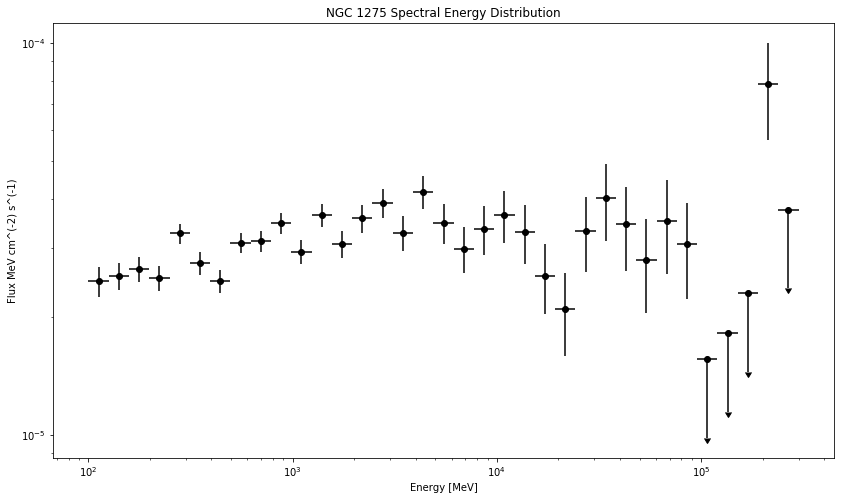

In [18]:
from matplotlib import pyplot as plt
%matplotlib inline


ts = sed['ts']
dnde = sed['dnde']
flux_error = sed['e2dnde_err']
e_min = sed['e_min']
e_ref = sed['e_ref']
e_max = sed['e_max']
uplim = sed['e2dnde_ul95']

flux = (e_ref**2)*dnde
yval = []
ts_int = []
uplim_bool = []
i = 0
i_array = []


while i < len(ts):
    ts_int.append(int(ts[i]))
    if ts_int[i] < 4:
        yval.append(uplim[i])
        uplim_bool.append(1)
        
    else:
        yval.append(flux[i])
        uplim_bool.append(0)
        i_array.append(i)
    i = i + 1

uplims = np.array(uplim_bool, dtype=bool)

low_xerr = []
high_xerr = []
j = 0

flux_valid = []
E_ctr_valid = []
for m in i_array:
    flux_valid.append(flux[m])
    E_ctr_valid.append(e_ref[m])


while j < len(e_ref):
    a = e_ref[j] - e_min[j]
    b = e_max[j] - e_ref[j]
    low_xerr.append(a)
    high_xerr.append(b)
    j = j + 1

xerr = [low_xerr, high_xerr]

fig = plt.subplots(figsize=(14, 8))
plt.errorbar(e_ref, uplim, xerr = xerr, yerr = flux_error
             , uplims = uplims, linestyle = 'None',
             color = 'black', marker = 'o')


plt.title('NGC 1275 Spectral Energy Distribution')
plt.xlabel('Energy [MeV]')
plt.ylabel('Flux MeV cm^(-2) s^(-1)')
plt.xscale('log')
plt.yscale('log')
plt.savefig('sed_NGC_1275.png', dpi = 400)

Now we've plotted our SED, lets take a look (it may or may not have shown up in the output of the above box). 

![SED](img/sed_NGC_1275.png)

That looks great! our code has plotted our SED, with error bars and energy bin widths, and plotted 95% confidence upper limits on bins where $ \sigma < 4$. We could, of course plot these points too, but low significannce bins have large error bars, and we aren't certain enough in them to take them seriously in any fit. We haven't fitted a line to our data, although if we wanted to, we could use $\chi ^2$ minimisation to fit a log parabola to it. 

You are more than welcome to plagarise this code for plotting, although it is actually pretty old and inelegant (I wrote it for an old analysis of the Crab Nebula). it works though, and thats what matters. 

Now we know that our SED has a log parabolic shape, and we can see the distributuion of flux with energy, what else can we do? 

So far we've been testing NGC 1275 as if it were a point source, however extension in Fermi sources does exist (although it is uncommon). Two radio galaxies are known to have extension: Centaurus A (our cloesest AGN neighbour) and Fornax A. Luckily Fermipy has a lovely routine called 'extension' to test whether a source is a point source, or is extended. Lets run it now and see what happens.

In [19]:
ext = gta.extension('4FGL J0319.8+4130')

2021-05-06 11:19:18 INFO    GTAnalysis.extension(): Running extension fit for 4FGL J0319.8+4130
2021-05-06 11:19:42 INFO    GTAnalysis._extension(): Fitting extended-source model.
2021-05-06 11:19:59 INFO    GTAnalysis._extension(): Generating TS map.
2021-05-06 11:20:17 INFO    GTAnalysis._extension(): Testing point-source model.
2021-05-06 11:20:28 INFO    GTAnalysis._extension(): Best-fit extension: 0.0171 + 0.0278 -    nan
2021-05-06 11:20:28 INFO    GTAnalysis._extension(): TS_ext:        0.046
2021-05-06 11:20:28 INFO    GTAnalysis._extension(): Extension UL: 0.0555
2021-05-06 11:20:28 INFO    GTAnalysis._extension(): LogLike:  -207040.734 DeltaLogLike:        5.744
2021-05-06 11:20:28 INFO    GTAnalysis.extension(): Finished extension fit.
2021-05-06 11:20:28 INFO    GTAnalysis.extension(): Execution time: 70.13 s


Now we've computed the extension of the source, lets take a look.

In [20]:
ext['ts_ext']

0.04597213497618213

There is a great deal of information in the numpy array produced by the extension algorithm. Luckily however, we are given a test statistic of extension. This test statistic gives us an indication as to how extended a source is. Remember, the square root of the TS is the significance! Thus our threshold for claiming extension is $TS = 25$ or $5 \sigma$. Our TS of extension is 0.05(ish) is far below this, and thus our hypothesis that NGC 1275 is a point source, remains correct. 

We can also look at the other parameters from the extension fit, but this is rather pointless considering that the source isn't extended! I'll leave it to your curiosity to explore. 

There are two other useful tools we'll explore with Fermipy for point source analysis. The first is localisation, which iteratively tests the position of our source in a whole load of different places, thus shifting our source position to the most likely place in the model. When we add our sources to the model from the catalogue, it takes the RA and Dec from the catalogued position. However, this might not always be the most accurate. In particular, we can use localisation to improve the positional accuracy of sources added with the find sources algorithm. Lets give it a go.

In [21]:
loc = gta.localize('4FGL J0319.8+4130')

2021-05-06 11:20:29 INFO    GTAnalysis.localize(): Running localization for 4FGL J0319.8+4130
/home/max/anaconda2/envs/fermipy/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
2021-05-06 11:21:00 WARNING GTAnalysis._localize(): Best-fit position outside of search region.
2021-05-06 11:21:00 WARNING GTAnalysis._localize(): Localization failed.  Keeping existing position.
2021-05-06 11:21:00 INFO    GTAnalysis._localize(): Localization completed with new position:
(  ra, dec) = (   49.9100 +/-   0.0059,   41.4765 +/-   0.0060)
(glon,glat) = (  150.5697 +/-   0.0077,  -13.3074 +/-   0.0034)
offset =   0.0503 r68 =   0.0074 r95 =   0.0119 r99 =   0.0148
2021-05-06 11:21:00 INFO    GTAnalysis._localize(): LogLike:  -207080.159 DeltaLogLike:      -33.306
2021-05-06 11:21:00 INFO    GTAnalysis.localize(): Finished localization.
2021-05-06 11:21:00 INFO    GTAnalysis.localize(): Execution

And we're done. Lets take a look inside the numpy array to see our new position.

In [22]:
loc['ra'], loc['dec']

(49.91000792334273, 41.47648549898735)

These are our best fit coordinates for NGC 1275, given our year of data. We can also see that they really aren't dramatically different to what they originally were. In fact, it would be very surprising and slightly worrying if they were!

Now on to the final key bit of point source analysis: the light-curve. Light-curves are one of the most useful, and powerful tools in an astronomers arsenal, an easy way to proble whether the flux of a source varies in time. Unfortunately, in Fermipy, they take a long time to make, due to the fact we need to compute the livetime in each bin. The command to produce a light-curve is slightly more complex than just putting in the name of our source, so we will go through these together now. 

First, we have the name of our source (obviously). Then we have the number of time bins in our light-curve. As we have 1 year of data, we can look at the flux in monthly bins. This is a sensible timescale, and with most objects it is difficult to see anything at all with smaller bins. Multithread allows our lightcurve algortithm to split up its jobs between the seperate cores on our computer, thus allowing us to simultaneously compute several bins at once. This has the effect of sppeding up our lightcurve by a factor of 2-4, with the side effect of essentially bricking our computer until its finished. Scaled source maps allow us again a huge advantage in computing speeds, by sacrificing a little accuracy in our modelling. This loss of accuracy is normally negligible, especially for an off the plane source like NGC 1275. Finally, by not saving bin data, we will prevent Fermipy from creating a seperate folder full of information for each bin. This can be a bit of an issue, especially when we are running a 100+ bin lightcurve!

Lets run it and see what happens.

In [23]:
lc = gta.lightcurve('4FGL J0319.8+4130', nbins=12, multithread=True,
                    use_scaled_srcmap=True, save_bin_data=False)

2021-05-06 11:21:01 INFO    GTAnalysis.lightcurve(): Computing Lightcurve for 4FGL J0319.8+4130
2021-05-06 11:21:01 INFO    lightcurve_283996802_286624802 GTAnalysis._process_lc_bin(): Fitting time range 283996802 286624802
2021-05-06 11:21:01 INFO    lightcurve_286624802_289252802 GTAnalysis._process_lc_bin(): Fitting time range 286624802 289252802
2021-05-06 11:21:01 INFO    lightcurve_289252802_291880802 GTAnalysis._process_lc_bin(): Fitting time range 289252802 291880802
2021-05-06 11:21:01 INFO    lightcurve_291880802_294508802 GTAnalysis._process_lc_bin(): Fitting time range 291880802 294508802
2021-05-06 11:21:03 INFO    lightcurve_286624802_289252802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:21:03 INFO    lightcurve_283996802_286624802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:21:03 INFO    lightcurve_291880802_294508802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:21:04 INFO    ligh

Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    273.423
Fitting shape 4FGL J0340.3+4130 TS:     50.622
Fitting shape 4FGL J0303.6+4716 TS:     16.202


2021-05-06 11:24:25 INFO    lightcurve_289252802_291880802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_289252802_291880802/fit_model_final_00.xml...
2021-05-06 11:24:26 INFO    lightcurve_289252802_291880802 GTAnalysis._process_lc_bin(): Finished time range 289252802 291880802
2021-05-06 11:24:26 INFO    lightcurve_294508802_297136802 GTAnalysis._process_lc_bin(): Fitting time range 294508802 297136802
2021-05-06 11:24:43 INFO    lightcurve_294508802_297136802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:25:05 INFO    lightcurve_286624802_289252802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_286624802_289252802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    245.635


2021-05-06 11:25:12 INFO    lightcurve_286624802_289252802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_286624802_289252802/fit_model_final_00.xml...
2021-05-06 11:25:13 INFO    lightcurve_286624802_289252802 GTAnalysis._process_lc_bin(): Finished time range 286624802 289252802
2021-05-06 11:25:14 INFO    lightcurve_297136802_299764802 GTAnalysis._process_lc_bin(): Fitting time range 297136802 299764802
2021-05-06 11:25:16 INFO    lightcurve_283996802_286624802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_283996802_286624802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']


2021-05-06 11:25:19 INFO    lightcurve_297136802_299764802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.


Fitting shape 4FGL J0319.8+4130 TS:    333.240


2021-05-06 11:25:23 INFO    lightcurve_283996802_286624802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_283996802_286624802/fit_model_final_00.xml...
2021-05-06 11:25:24 INFO    lightcurve_283996802_286624802 GTAnalysis._process_lc_bin(): Finished time range 283996802 286624802
2021-05-06 11:25:24 INFO    lightcurve_299764802_302392802 GTAnalysis._process_lc_bin(): Fitting time range 299764802 302392802
2021-05-06 11:25:27 INFO    lightcurve_299764802_302392802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:25:34 INFO    lightcurve_291880802_294508802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_291880802_294508802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    488.827
Fitting shape 4FGL J0340.3+4130 TS:     47.337
Fitting shape 4FGL J0303.6+4716 TS:     26.321


2021-05-06 11:25:43 INFO    lightcurve_291880802_294508802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_291880802_294508802/fit_model_final_00.xml...
2021-05-06 11:25:43 INFO    lightcurve_291880802_294508802 GTAnalysis._process_lc_bin(): Finished time range 291880802 294508802
2021-05-06 11:25:44 INFO    lightcurve_302392802_305020802 GTAnalysis._process_lc_bin(): Fitting time range 302392802 305020802
2021-05-06 11:25:46 INFO    lightcurve_302392802_305020802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:30:24 INFO    lightcurve_302392802_305020802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_302392802_305020802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:   1340.522
Fitting shape 4FGL J0340.3+4130 TS:     43.058
Fitting shape 4FGL J0303.6+4716 TS:     20.693


2021-05-06 11:30:32 INFO    lightcurve_302392802_305020802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_302392802_305020802/fit_model_final_00.xml...
2021-05-06 11:30:33 INFO    lightcurve_302392802_305020802 GTAnalysis._process_lc_bin(): Finished time range 302392802 305020802
2021-05-06 11:30:34 INFO    lightcurve_305020802_307648802 GTAnalysis._process_lc_bin(): Fitting time range 305020802 307648802
2021-05-06 11:30:38 INFO    lightcurve_305020802_307648802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:30:51 INFO    lightcurve_297136802_299764802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_297136802_299764802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    675.058
Fitting shape 4FGL J0303.6+4716 TS:    182.295
Fitting shape 4FGL J0222.6+4302 TS:     18.887


2021-05-06 11:30:58 ERROR   lightcurve_297136802_299764802 GTAnalysis.fit(): MINUIT failed with status code 102 fit quality 2
2021-05-06 11:30:58 INFO    lightcurve_297136802_299764802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_297136802_299764802/fit_model_final_00.xml...
2021-05-06 11:30:59 INFO    lightcurve_297136802_299764802 GTAnalysis._process_lc_bin(): Finished time range 297136802 299764802
2021-05-06 11:31:00 INFO    lightcurve_307648802_310276802 GTAnalysis._process_lc_bin(): Fitting time range 307648802 310276802
2021-05-06 11:31:13 INFO    lightcurve_307648802_310276802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:31:16 INFO    lightcurve_299764802_302392802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_299764802_302392802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']


2021-05-06 11:31:21 INFO    lightcurve_294508802_297136802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_294508802_297136802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:   1676.184
Fitting shape 4FGL J0303.6+4716 TS:     61.715
Fitting shape 4FGL J0324.8+3412 TS:     41.291


2021-05-06 11:31:24 INFO    lightcurve_299764802_302392802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_299764802_302392802/fit_model_final_00.xml...
2021-05-06 11:31:25 INFO    lightcurve_299764802_302392802 GTAnalysis._process_lc_bin(): Finished time range 299764802 302392802
2021-05-06 11:31:26 INFO    lightcurve_310276802_312904802 GTAnalysis._process_lc_bin(): Fitting time range 310276802 312904802
2021-05-06 11:31:27 INFO    lightcurve_310276802_312904802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.


Fitting shape 4FGL J0319.8+4130 TS:    751.830
Fitting shape 4FGL J0340.3+4130 TS:     46.486
Fitting shape 4FGL J0303.6+4716 TS:     30.511
Fitting shape 4FGL J0324.8+3412 TS:     28.479


2021-05-06 11:31:30 INFO    lightcurve_294508802_297136802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_294508802_297136802/fit_model_final_00.xml...
2021-05-06 11:31:31 INFO    lightcurve_294508802_297136802 GTAnalysis._process_lc_bin(): Finished time range 294508802 297136802
2021-05-06 11:31:31 INFO    lightcurve_312904802_315532802 GTAnalysis._process_lc_bin(): Fitting time range 312904802 315532802
2021-05-06 11:31:39 INFO    lightcurve_312904802_315532802 GTBinnedAnalysis._create_ltcube(): Generating local LT cube.
2021-05-06 11:33:08 INFO    lightcurve_305020802_307648802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_305020802_307648802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    911.274
Fitting shape 4FGL J0303.6+4716 TS:     90.307
Fitting shape 4FGL J0340.3+4130 TS:     25.104


2021-05-06 11:33:16 ERROR   lightcurve_305020802_307648802 GTAnalysis.fit(): MINUIT failed with status code 102 fit quality 2
2021-05-06 11:33:17 INFO    lightcurve_305020802_307648802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_305020802_307648802/fit_model_final_00.xml...
2021-05-06 11:33:17 INFO    lightcurve_305020802_307648802 GTAnalysis._process_lc_bin(): Finished time range 305020802 307648802
2021-05-06 11:33:30 INFO    lightcurve_310276802_312904802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_310276802_312904802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:   1208.947
Fitting shape 4FGL J0303.6+4716 TS:    112.846
Fitting shape 4FGL J0340.3+4130 TS:     44.334


2021-05-06 11:33:37 ERROR   lightcurve_310276802_312904802 GTAnalysis.fit(): MINUIT failed with status code 102 fit quality 2


Fitting shape PS J0347.4+4403 TS:     21.595


2021-05-06 11:33:37 INFO    lightcurve_310276802_312904802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_310276802_312904802/fit_model_final_00.xml...
2021-05-06 11:33:38 INFO    lightcurve_310276802_312904802 GTAnalysis._process_lc_bin(): Finished time range 310276802 312904802
2021-05-06 11:33:46 INFO    lightcurve_307648802_310276802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_307648802_310276802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    953.522
Fitting shape 4FGL J0303.6+4716 TS:    160.589


2021-05-06 11:33:54 INFO    lightcurve_307648802_310276802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_307648802_310276802/fit_model_final_00.xml...
2021-05-06 11:33:54 INFO    lightcurve_307648802_310276802 GTAnalysis._process_lc_bin(): Finished time range 307648802 310276802
2021-05-06 11:34:54 INFO    lightcurve_312904802_315532802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_312904802_315532802/base_00.xml...


Joint fit  ['4FGL J0319.8+4130', '4FGL J0303.6+4716']
Fitting shape 4FGL J0319.8+4130 TS:    893.056
Fitting shape 4FGL J0303.6+4716 TS:     92.157
Fitting shape 4FGL J0324.8+3412 TS:     33.070
Fitting shape 4FGL J0359.6+5057 TS:     16.188


2021-05-06 11:35:01 INFO    lightcurve_312904802_315532802 GTBinnedAnalysis.write_xml(): Writing /run/media/max/MAXSDRIVE/Tutorial/NGC_1275_Fit/lightcurve_312904802_315532802/fit_model_final_00.xml...
2021-05-06 11:35:02 INFO    lightcurve_312904802_315532802 GTAnalysis._process_lc_bin(): Finished time range 312904802 315532802
2021-05-06 11:35:10 INFO    GTAnalysis.lightcurve(): Finished Lightcurve


gta.lightcurve will not produce diagnostic plots, so we need to plot these ourselves. This code will plot it for you, but I recommend that you don't try and copy it. Its s##t, and was written for a very tempramental Centos 7 OS setup. 

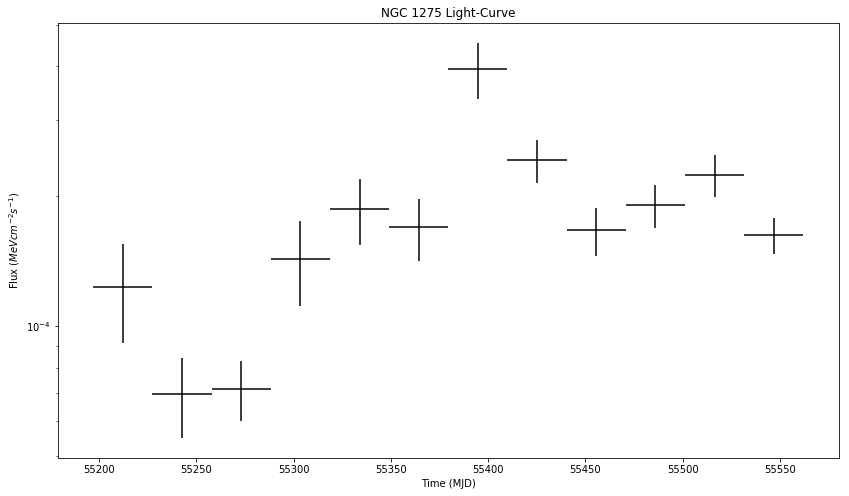

In [24]:
ts_1 = lc['ts']
tmin_1 = lc['tmin_mjd']
tmax_1 = lc['tmax_mjd']
flux_1 = lc['eflux']
ul_1 = lc['eflux_ul95']
flux_err_1 = lc['eflux_err']
tcen = []
i = 0

ts = []
tmin = []
tmax = []
flux = []
ul = []
flux_err = []
i = 0
while i < len(ts_1):
    ts.append(ts_1[i])
    tmin.append(tmin_1[i])
    tmax.append(tmax_1[i])
    flux.append(flux_1[i])
    ul.append(ul_1[i])
    flux_err.append(flux_err_1[i])
    i = i + 1


where_are_NaNs = np.isnan(ts)
i = 0
while i < len(where_are_NaNs):
    if where_are_NaNs[i]==True:
        ts[i] = 0
        tmin[i] = 0
        tmax[i] = 0
        flux[i] = 0
        ul[i] = 0
        flux_err[i] = 0
        i = i + 1
    else:
        i = i + 1

i = 0
while i < len(ts):
    if ts[i] == 0:
        ts.remove(ts[i])
        tmin.remove(tmin[i])
        tmax.remove(tmax[i])
        flux.remove(flux[i])
        ul.remove(ul[i])
        flux_err.remove(flux_err[i])
        i = i - 1
    i = i + 1

i = 0
while i < len(tmin):
    t = (tmin[i] + tmax[i])/2
    tcen.append(t)
    i = i + 1

flux_plot = []
flux_err_plot = []
ts_int = []
uplim_bool = []
j = 0

while j < len(ts):
    ts_int.append(int(ts[j]))
    
    if ts_int[j] < 4:                ### CHANGE TS THRESHOLD HERE
        flux_plot.append(ul[j])
        uplim_bool.append(1)
        flux_err_plot.append(2e-6)
        
    else:
        flux_plot.append(flux[j])
        uplim_bool.append(0)
        flux_err_plot.append(flux_err[j])
    j = j + 1
    
uplims = np.array(uplim_bool, dtype = bool)

low_xerr = []
k = 0

while k < len(tcen):
    a = tcen[k] - tmin[k]
    low_xerr.append(a)
    k = k + 1
high_xerr = low_xerr
    
xerr = [low_xerr, high_xerr]

fig = plt.subplots(figsize=(14, 8))
plt.errorbar(tcen, flux_plot, xerr = xerr, yerr = flux_err_plot,
             uplims = uplims, linestyle = 'None', color = 'k',
             marker = 'None')
plt.title('NGC 1275 Light-Curve')
plt.xlabel('Time [MJD]')
plt.ylabel('Flux MeV cm^(-2) s^(-1)')
plt.yscale('log')
plt.xlabel("Time (MJD)")
plt.ylabel("Flux ($MeV cm^{-2} s^{-1}$)")
plt.savefig('NGC_1275_lc', dpi=400)

Lets have a look!

![lc](img/NGC_1275_lc.png)

That is verrrry variable! NGC 1275 is a very gamma bright source, and is famous for it's variability (well, as famous as a gamma-ray emitting radio galaxy can be). Anthony reckons he's gotten the bin sizes down to 12 hours before, which is frankly astounding for an object of this nature. Again, we can fit a curve to this data, but for now we are done!

Congratulations, you have just executed a more or less complete analysis of a radio galaxy using a NASA space telescope! 

![welldone](img/welldone.jpg)

If you are ready for more of a challenge, then lets look at the Crab Nebula. The Crab Nebula consists of a pulsar wind nebula (4FGL J0534.5+2201e) and it's central pulsar both are spatially coincident with eachother, however the Crab is on the galactic plane, so this is more of a challenge for us to model. 

To look at the Crab, you will need to download a dataset for it (following the instructions in tutorial 1) and then write a config (you can copy and change the NGC 1275 one) and execute an analysis chain in Fermipy. I'd recommend setting up a seperate directory to do this in. The methods should be largely the same! I've studied the Crab as a project before, so if you have any issues, please let me know!